In [1]:
import ROOT
import ROOT.ROOT as rr

import uproot
import numpy as np
import pandas as pd
import os
from pathlib import Path
import awkward as ak

import random

import FilterFunctions as ff
import cpp

Welcome to JupyROOT 6.24/00


### Implementation of the skimming step of the analysis

The skimming step reduces the inital generic samples to a dataset optimized for this specific analysis. Most important, the skimming removes all events from the initial dataset, which are not of interest for our study.

In [2]:
dirBasePath  = '/data/FCNC/'
dirOutPath = '/data/Skim/'
dirPlotPath = './Plots/'

listDir = os.listdir(dirBasePath)

In [3]:
def returnDir(string):
    return [filename for filename in listDir if filename.startswith(string)]

def loadData(chain, pathDirs, info=False):
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
    
    for Dir in pathDirs:
        if info: print('>>> Process directory ', Dir)
        file_list = os.listdir(dirBasePath + Dir)
        for file in file_list:
            chain.AddFile(dirBasePath + Dir + '/' + file)
            
    return chain

def CountEvents(df):
    n = df.Count().GetValue()
    print('\nNumber of events:', n, '\n')

#### List of all MC background directories

'DYJetsToLL_M', 'QCD', 'ST_s', 'ST_t', 'ST_tW_antitop', 'ST_tW_top', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic',
'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu', 'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG',
'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu', 'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq'

In [4]:
# - Data + MC Signal
signalDirs = returnDir('SingleMuon')
signalMCDirs = returnDir('TT_FCNC')

# - MC backgrounds
listBkgDir = ['ST_', 'TTTT_Tune', 'TTTo2L2Nu', 'TTToHadronic', 'TTToSemiLeptonic', 'TTWJetsToLNu', 'TTZToLLNuNu',
              'WGToLNuG', 'WJetsToLNu', 'WWTo2L2Nu', 'WWW', 'WWZ', 'WZG', 'WZTo1L1Nu2Q', 'WZTo2L2Q', 'WZTo3LNu',
              'WZZ', 'WmWmJJ', 'WminusH', 'WpWpJJ', 'ZG', 'ZZ', 'tZq', 'DYJetsToLL_M', 'QCD']

bkgMCDirs = dict(list(zip(listBkgDir, map(returnDir, listBkgDir))))
bkgMCChain = dict(list(zip(listBkgDir, [ROOT.TChain('Events') for _ in range(len(listBkgDir))])))

In [5]:
# - Load Data + MC Signal

chainSig = ROOT.TChain('Events')
dfData = rr.RDataFrame(loadData(chainSig, signalDirs))
# CountEvents(dfData)

chainMC = ROOT.TChain('Events')
dfMCSig = rr.RDataFrame(loadData(chainMC, signalMCDirs))
# CountEvents(dfMCSig)

In [6]:
# -Load MC backgrounds

dfMCBkg = {}
for key, value in bkgMCDirs.items():
    dfMCBkg[key] = rr.RDataFrame(loadData(bkgMCChain[key], value))
#     CountEvents(dfMCBkg[key])

### Read skimmed file

In [ ]:
%%bash

rm /data/Skim/DataFlat2.root

In [ ]:
%%bash

ls /data/Skim

In [ ]:
ff.DeclareVariables2(dfData, 'Data', save=True)

In [ ]:
file = uproot.open(dirOutPath + 'DataFlat2.root')
tree = file['Events']
# tree.keys()
df = tree.arrays(['inv_m', 'mu_pt', 'el_pt'], library='pd')
max(df.inv_m)
# df[df.lep_q0 == 0]['lep_charge']
# df.loc[(df['inv_m'] < 15) & (df['inv_m02'] < 15) & (df['inv_m12'] < 15)]

### Histograms: save in `.root` extension

In [7]:
ROOT.gROOT.SetBatch(True)

################################################################################
# Declare the range of the histogram for each variable
#
# Each entry in the dictionary contains of the variable name as key and a tuple
# specifying the histogram layout as value. The tuple sets the number of bins,
# the lower edge and the upper edge of the histogram.
################################################################################

default_nbins = 30
ranges = {
#         'Electron_pt15': (default_nbins, 15, 200),
        'mu_pt': (default_nbins, 15, 200),
        'el_pt': (default_nbins, 15, 200),
        'inv_m': (20, 15, 500),
#         'Electron_eta': (default_nbins, -5, 5),
#         'Muon_eta': (default_nbins, -5, 5),
#         'Jet_pt': (default_nbins, 10, 500),
#         'Jet_eta': (default_nbins, -5, 5),
        }

# Book a histogram for a specific variable
def bookHistogram(df, variable, range_):
    return df.Histo1D(rr.RDF.TH1DModel(variable, variable, range_[0], range_[1], range_[2]), variable, 'eventWeightLumi')

# Write a histogram with a given name to the output ROOT file
def writeHistogram(h, name):
    h.SetName(name)
    h.Write()

################################################################################
# Main function of the histogramming step
#
# The function loops over the outputs from the skimming step and produces the
# required histograms for the final plotting.
################################################################################

def main(nSkim):
    # Set up multi-threading capability of ROOT
    rr.EnableImplicitMT()
 
    # Create output file
    tfile = ROOT.TFile(dirPlotPath + 'Trials/prova_legenda{}.root'.format(nSkim), 'RECREATE')
    variables = ranges.keys()
    
    fdfData = ff.DeclareVariables[nSkim](dfData, '', save=False)
#     fdfMC = ff.DeclareVariables[nSkim](dfMC)
    
    # Loop through skimmed datasets and produce histograms of variables
    hists = {}
    for variable in variables:
        hists[variable] = bookHistogram(fdfData, variable, ranges[variable])

#     hists_mc = {}
#     for variable in variables:
#         hists_mc[variable] = bookHistogram(fdfMC, variable, ranges[variable])

    # Write histograms to output file
    for variable in variables:
        writeHistogram(hists[variable], '{}_{}'.format('data', variable))
#     for variable in variables:
#         writeHistogram(hists_mc[variable], '{}_{}'.format('MCSig', variable))
        
    
    for key, value in dfMCBkg.items():
        fdfMCBkg = ff.DeclareVariables[nSkim](value, '', save=False)
        
        hists = {}
        for variable in variables:
            hists[variable] = bookHistogram(fdfMCBkg, variable, ranges[variable])
        for variable in variables:
            writeHistogram(hists[variable], '{}_{}'.format(key, variable))
    
    tfile.Close()

if __name__ == '__main__':
    main(2)

### Final plotting

In [14]:
################################################################################
# Implementation of the plotting step of the analysis
################################################################################

# Declare a human-readable label for each variable
labels = {
#         'Electron_pt15': 'Electron p_{T} / GeV',
        'mu_pt': 'Muon p_{T} / GeV',
        'el_pt': 'Electron p_{T} / GeV',
        'inv_m': 'Dimuon invariant mass / GeV',
#         'Electron_eta': 'Electron #eta',
#         'Muon_eta': 'Muon #eta',
#         'Jet_pt': 'Jet p_{T} / GeV',
#         'Jet_eta': 'Jet #eta',
        }

# Specify the color for each process

# - Signal
colors = {
        'data': ROOT.TColor.GetColor('#BF2229'),
        'MCSig': ROOT.TColor.GetColor('#00A88F'),
        }
### - MC BKG
colorsBkg = {
    'ST_': ROOT.TColor.GetColor(222, 90, 106),
    'TTTT_Tune': ROOT.TColor.GetColor(248, 206, 104),
    'TTTo2L2Nu': ROOT.TColor.GetColor(248, 206, 104),
    'TTToHadronic': ROOT.TColor.GetColor(248, 206, 104),
    'TTToSemiLeptonic': ROOT.TColor.GetColor(248, 206, 104),
    'TTWJetsToLNu': ROOT.TColor.GetColor(155, 152, 204),
    'TTZToLLNuNu': ROOT.TColor.GetColor(247, 138, 221),
    'WGToLNuG': ROOT.TColor.GetColor(250, 202, 255),
    'WJetsToLNu': ROOT.TColor.GetColor(250, 202, 255),
    'WWTo2L2Nu': ROOT.TColor.GetColor(250, 202, 255),
    'WWW': ROOT.TColor.GetColor(250, 202, 255),
    'WWZ': ROOT.TColor.GetColor(250, 202, 255),
    'WZG': ROOT.TColor.GetColor(250, 202, 255),
    'WZTo1L1Nu2Q': ROOT.TColor.GetColor(250, 202, 255),
    'WZTo2L2Q': ROOT.TColor.GetColor(250, 202, 255),
    'WZTo3LNu': ROOT.TColor.GetColor(250, 202, 255),
    'WZZ': ROOT.TColor.GetColor(250, 202, 255),
    'WmWmJJ': ROOT.TColor.GetColor(250, 202, 255),
    'WminusH': ROOT.TColor.GetColor(250, 202, 255),
    'WpWpJJ': ROOT.TColor.GetColor(250, 202, 255),
    'ZG': ROOT.TColor.GetColor(250, 202, 255),
    'ZZ': ROOT.TColor.GetColor(250, 202, 255),
    'tZq': ROOT.TColor.GetColor(100, 192, 232),
    'DYJetsToLL_M': ROOT.TColor.GetColor(100, 192, 232),
    'QCD': ROOT.TColor.GetColor(100, 192, 232),
}

# Retrieve a histogram from the input file based on the process and the variable name
def getHistogram(tfile, name, variable, tag=''):
    name = '{}_{}{}'.format(name, variable, tag)
    h = tfile.Get(name)
    if not h:
        raise Exception('Failed to load histogram {}.'.format(name))
    return h

################################################################################

# Main function of the plotting step
def main(variable, nSkim):
    tfile = ROOT.TFile(dirPlotPath + 'Trials/prova_legenda{}.root'.format(nSkim), 'READ')

    # Styles
    ROOT.gStyle.SetOptStat(0)

    ROOT.gStyle.SetCanvasBorderMode(0)
    ROOT.gStyle.SetCanvasColor(ROOT.kWhite)
    ROOT.gStyle.SetCanvasDefH(600)
    ROOT.gStyle.SetCanvasDefW(600)
    ROOT.gStyle.SetCanvasDefX(0)
    ROOT.gStyle.SetCanvasDefY(0)

    ROOT.gStyle.SetPadTopMargin(0.08)
    ROOT.gStyle.SetPadBottomMargin(0.13)
    ROOT.gStyle.SetPadLeftMargin(0.16)
    ROOT.gStyle.SetPadRightMargin(0.05)

    ROOT.gStyle.SetHistLineColor(1)
    ROOT.gStyle.SetHistLineStyle(0)
    ROOT.gStyle.SetHistLineWidth(1)
    ROOT.gStyle.SetEndErrorSize(2)
    ROOT.gStyle.SetMarkerStyle(20)

    ROOT.gStyle.SetOptTitle(0)
    ROOT.gStyle.SetTitleFont(42)
    ROOT.gStyle.SetTitleColor(1)
    ROOT.gStyle.SetTitleTextColor(1)
    ROOT.gStyle.SetTitleFillColor(10)
    ROOT.gStyle.SetTitleFontSize(0.05)

    ROOT.gStyle.SetTitleColor(1, 'XYZ')
    ROOT.gStyle.SetTitleFont(42, 'XYZ')
    ROOT.gStyle.SetTitleSize(0.05, 'XYZ')
    ROOT.gStyle.SetTitleXOffset(1.00)
    ROOT.gStyle.SetTitleYOffset(1.60)

    ROOT.gStyle.SetLabelColor(1, 'XYZ')
    ROOT.gStyle.SetLabelFont(42, 'XYZ')
    ROOT.gStyle.SetLabelOffset(0.007, 'XYZ')
    ROOT.gStyle.SetLabelSize(0.04, 'XYZ')

    ROOT.gStyle.SetAxisColor(1, 'XYZ')
    ROOT.gStyle.SetStripDecimals(True)
    ROOT.gStyle.SetTickLength(0.03, 'XYZ')
    ROOT.gStyle.SetNdivisions(510, 'XYZ')
    ROOT.gStyle.SetPadTickX(1)
    ROOT.gStyle.SetPadTickY(1)

    ROOT.gStyle.SetPaperSize(20., 20.)
    ROOT.gStyle.SetHatchesLineWidth(5)
    ROOT.gStyle.SetHatchesSpacing(0.05)

    ROOT.TGaxis.SetExponentOffset(-0.08, 0.01, 'Y')
    
    legend = ROOT.TLegend(0.6, 0.6, 0.9, 0.8)
    legend.SetNColumns(2)

    # Data + MC
    data = getHistogram(tfile, 'data', variable)
#     MCSig = getHistogram(tfile, 'MCSig', variable)
    
    stack = ROOT.THStack('', '')
    seen, count = [], 0
    titles = ['Single top', 'top', 'ttW', 'ttZ','Diboson', 'Others']
    for key, value in colorsBkg.items():
        histo = getHistogram(tfile, key, variable)
        histo.SetLineWidth(0)
        histo.SetFillColor(value)
        stack.Add(histo)
        if value not in seen:
            legend.AddEntry(histo, titles[count], 'f')
            count += 1
            seen.append(value)

    # Draw histograms
    data.SetMarkerStyle(20)
    data.SetLineColor(ROOT.kBlack)
    data.SetLineWidth(3)
#     MCSig.SetLineColor(colors['MCSig'])
#     MCSig.SetLineWidth(3)

    c = ROOT.TCanvas('', '', 600, 600)
    
    name = data.GetTitle()
    if name in labels:
        title = labels[name]
    else:
        title = name

#     MCSig.Draw('HIST SAME')
    stack.Draw('hist')
    data.Draw('E1P SAME')
    
    stack.GetXaxis().SetTitle(labels[variable])
    stack.GetYaxis().SetTitle('N_{Events}')
    stack.SetMaximum(max(stack.GetMaximum(), data.GetMaximum()) * 1.2)
    stack.SetMinimum(1.0)

    # Add legend
#     legend.AddEntry(MCSig, 'MCSig', 'f')
    legend.AddEntry(data, 'Data', 'lep')
    legend.SetBorderSize(0)
    legend.Draw()

    # Add title
    latex = ROOT.TLatex()
    latex.SetNDC()
    latex.SetTextSize(0.04)
    latex.SetTextFont(42)
    latex.DrawLatex(0.16, 0.935, '#bf{CMS FCNC}')

    # Save
#     c.SaveAs(dirPlotPath + '{}_{}'.format(variable, nSkim))
    c.SaveAs(dirPlotPath + 'Trials/{}_{}iSkim2_86.png'.format(variable, nSkim))
#     ROOT.gROOT.GetListOfCanvases().Draw()

# Loop over all variable names and make a plot for each
if __name__ == '__main__':
    for variable in labels.keys():
        main(variable, 2)

Info in <TCanvas::Print>: png file ./Plots/Trials/mu_pt_2iSkim2_86.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/el_pt_2iSkim2_86.png has been created
Info in <TCanvas::Print>: png file ./Plots/Trials/inv_m_2iSkim2_86.png has been created


el_pt_2iSkim2_86.png



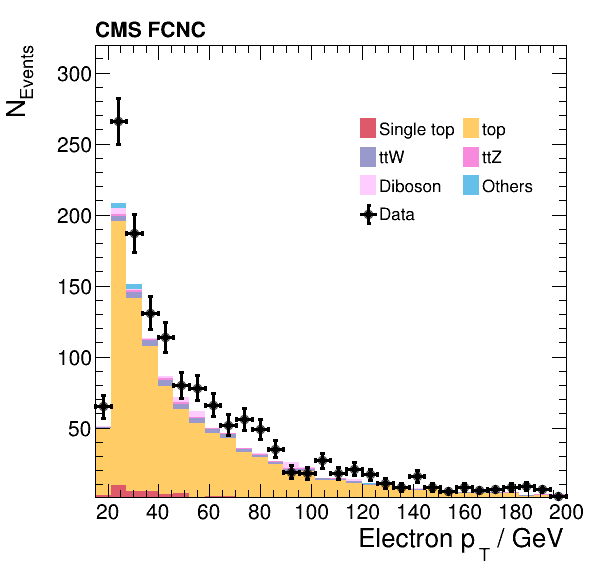

inv_m_2iSkim2_86.png



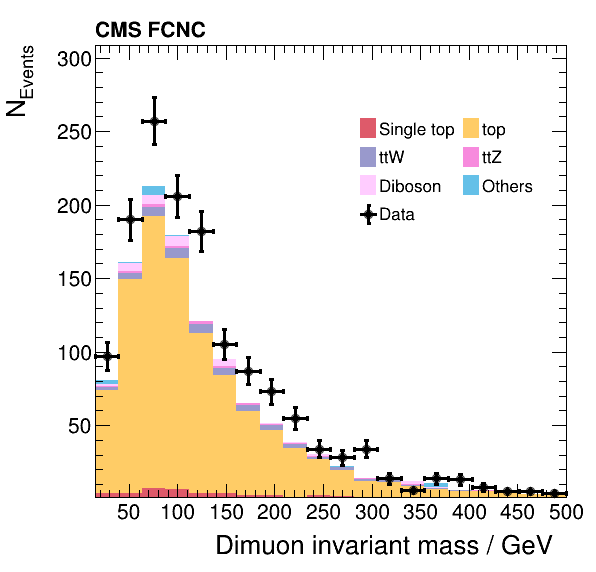

mu_pt_2iSkim2_86.png



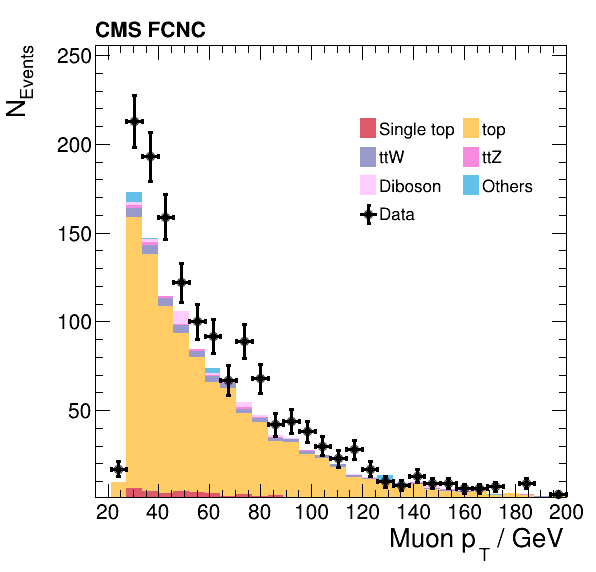

In [15]:
from IPython.display import Image
for image in sorted(os.listdir(dirPlotPath + 'Trials/')):
    if image.endswith('iSkim2_86.png'):
        print(image + '\n')
        display(Image(filename=(dirPlotPath + 'Trials/' + image)))

***
### Examples and trials

### Using UPROOT

In [ ]:
def compute_m(p1, p2, phi1, phi2, eta1, eta2):
    return np.sqrt(2*p1*p2*(np.cosh(eta1-eta2) - np.cos(phi1-phi2)))

In [ ]:
file = uproot.open(dirOutPath + 'DataFlat4.root')
tree = file['Events']
# tree.keys()
df = tree.arrays(library='pd')

In [ ]:
df['m_inv01'] = df.apply(lambda x: compute_m(x.mu_pt1, x.mu_pt0, x.mu_phi1, x.mu_phi0, x.mu_eta1, x.mu_eta0), axis=1)

In [ ]:
df.iloc[100:130]

In [ ]:
z = df[df['mu_q1']*df['mu_q0'] == -1]

In [ ]:
import matplotlib.pyplot as plt

plt.hist(df.m_inv01, bins=100)
plt.hist(df.m_inv01, bins=100, histtype='step')
# plt.vlines(90, 0, 300, color='red')
plt.show()

In [ ]:
files = uproot.concatenate([(samplesBasePath + folder + '/*.root:Events') for folder in signalDirs])
dataframe = ak.to_pandas(files)
dataframe

### Flattening trial

In [ ]:
flat = FSkim3(dfData).Define('Muon_0', 'Muon_pt15[0]')\
                     .Define('Muon_2', 'Muon_pt15[2]')

In [ ]:
prova = flat.AsNumpy(columns=['Muon_0'])
prova

### Histogram example

In [ ]:
histo = FSkim3(dfData).Histo1D(rr.RDF.TH1DModel('nJet', 'nJet', 15, 0, 15), 'nJet')
c = ROOT.TCanvas('Hist','',800,600);
c.cd();
histo.Draw();
c.Draw();

In [ ]:
%%cpp
// example of filtering operation MC events
using namespace ROOT;

RDataFrame d('Events', '/data/FCNC/TT_FCNC-aTtoHJ_Tleptonic_HToWWZZtautau_eta_hct-MadGraph5-pythia8_RunIISummer16/6319226B-F5F4-1B45-950E-36BE5993AA49_Skim.root');
//auto c = d.Filter('iSkim != 1 && iSkim != 2 && iSkim != 3 && iSkim != 4').Count();
//std::cout << *c << std::endl;
                
hz = d.Histo1D('nElectron');

### Processing file by file w/o `Chain`

In [ ]:
# def main():

# Set up multi-threading capability of ROOT
rr.EnableImplicitMT()

for signalDir in signalDirs:
    print('>>> Process directory ', signalDir, ':')

#     df = rr.RDataFrame('Events' samplesBasePath + signalDir + '/*.root')
#     print('Number of events:', df.Count())

    df2 = MinimalSelection(df)
    
    df2.Report().Snapshot('Events', dirOutPath + signalDir + 'Fltr.root', finalVariables);

***
Loading of `.root` files through flattening with `uproot`.

In [ ]:
uproot.lazy([basepath+'SingleMuon_Run2017B-Nano1June2019-v1/*.root:Events'], filter_name='nMuon')

In [ ]:
uproot.concatenate([basepath + '{}/*.root:events'.format(folder for folder in return_dir('SingleMuon'))], filter_name='nMuon')

#### To clarify:
- massa invariante: problema a 15GeV per iSkim3
- errore sul MC

#### To do:
- MC raggruppati
- criteri discriminazione e/mu (e -> 11, mu -> 13)
- fare un po' di plot per iSkim2 (alzare taglio pt muon o isolamento)
- ricostruire info jet
- tagliare più duro su iSkim2


- m_eff

#### Prossimamente:
- BDT: discriminazione segnale/bkg
- Esame MAPD